<a href="https://colab.research.google.com/github/Alok130802/Text-Classification/blob/master/BBC_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Librariers

In [1]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc,roc_curve,classification_report
import seaborn as sns
from sklearn.pipeline import Pipeline
import re
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from joblib import load,dump

# Load Dataset

In [2]:
data = pd.read_csv('Intent_data_final.csv')

In [3]:
data.head()

,Unnamed: 0,Text,Category
0,0,prince idol hero,News
1,1,thought 116062 ’ christmas stuff early yet htt...,Marketing
2,2,tmobilehelp ’ rabbit hole ... send another dm 🤞🙏,Marketing
3,3,u.s. protects environment nixon trump,News
4,4,hello teacher course interest make know korean...,Feedback


In [4]:
list_category = data['Category'].unique()
list_category = list_category.tolist()

# EDA on dataset 
 we can see that we have almost balanced class dataset 
 

In [5]:
data.groupby(['Category']).size()

Category
Feedback     50000
Marketing    50000
News         49998
Query        50000
Spam         55043
dtype: int64

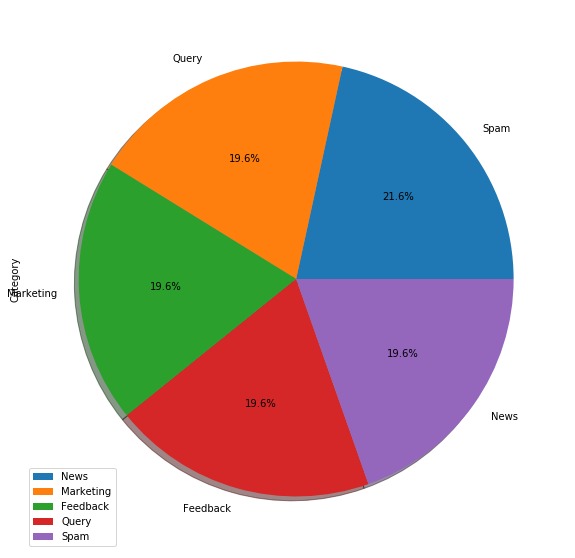

In [6]:
data["Category"].value_counts().plot(kind = 'pie',figsize = (10, 10), autopct = '%1.1f%%', shadow = True)

plt.legend(list_category)
plt.show()

## Split to train and test 

In [7]:
train,test = train_test_split(data,random_state = 0,stratify = data['Category'],test_size = 0.2)

In [8]:
print("Train data shape = {} ".format(train.shape))
print("Test data shape = {}".format(test.shape))

Train data shape = (204032, 3) 
Test data shape = (51009, 3)


        Unnamed: 0                                               Text Category
116643      116643                                  law takes holiday     News
56887        56887         home school nothing lot homework want help     Spam
166464      166464  On what date was it announced that the capital...    Query
156089      156089             major blow obama ’ climate-change plan     News
34849        34849  In what work is the goal to record the extent ...    Query


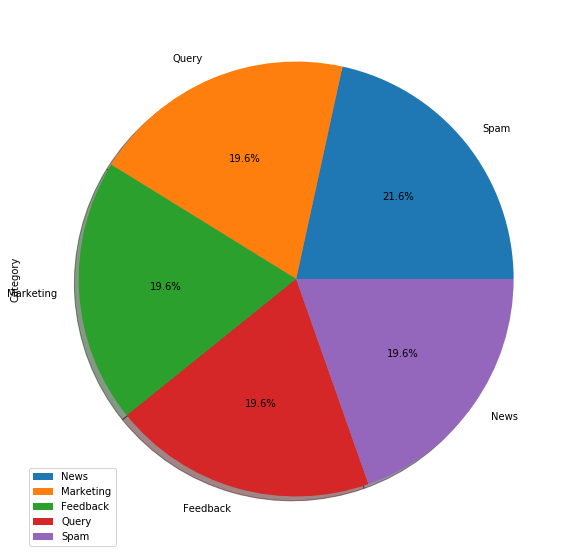

In [9]:
train["Category"].value_counts().plot(kind = 'pie',figsize = (10, 10), autopct = '%1.1f%%', shadow = True)

plt.legend(list_category)
print(train.head())
plt.show()

        Unnamed: 0                                               Text  \
159821      159821  's good introductory course bim reading conten...   
19203        19203                                          reckoning   
96136        96136  n't look back building coat n't want get sick ...   
1898          1898    Which side of the state has more precipitation?   
156448      156448  british teen decide join islamic state syria f...   

        Category  
159821  Feedback  
19203       News  
96136       Spam  
1898       Query  
156448      News  


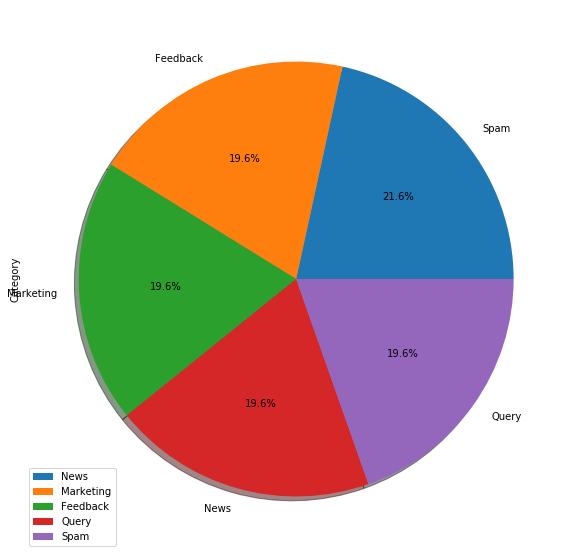

In [10]:
test["Category"].value_counts().plot(kind = 'pie',figsize = (10, 10), autopct = '%1.1f%%', shadow = True)
print(test.head())
plt.legend(list_category)
plt.show()

This function is used to remove everything except alphacharacters and spaces


In [11]:
def preprocess(sms):
  pattern = re.compile('[^[A-Za-z\s]')
  sms = re.sub(pattern,' ',sms)
  sms = re.sub('\s+',' ',sms)
  sms = sms.lower()
  return sms

In [13]:
train= train.astype(str)
train['Text'] = train['Text'].map(lambda x :preprocess(x))

Use Label Encode to encode categories and use Tf-Idf to vactorize the text data

In [14]:
encoder = LabelEncoder()
vectorizer  = TfidfVectorizer()

train_x = vectorizer.fit_transform(train['Text'])
train_y = encoder.fit_transform(train['Category'])

Train model using grid search and 10 fold cross validation

In [15]:
param_grid = dict({"alpha":[1,10,100],
                   'fit_prior' :[True,False]})
grid = GridSearchCV(MultinomialNB(),param_grid,cv=10)
grid.fit(train_x,train_y)



GridSearchCV(cv=10, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1, 10, 100], 'fit_prior': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [19]:
def scoring_data(grid,data):
  x = vectorizer.transform(data['Text'].values.astype('U'))
  y = encoder.transform(data['Category'].values.astype('U'))
  score = grid.score(x,y)
  print("Accuracy of Model is {}".format(score))
  y_pred = grid.predict(x)
  confution_matrix = confusion_matrix(y_pred,y)
  print(classification_report(y,y_pred=y_pred))
  sns.heatmap(confution_matrix,annot=True,fmt='d',cmap = 'BuPu',xticklabels=list_category,yticklabels=list_category)

# Score of Model
we can see that we achieved 88% accuracy using MultinomialNB Model 

Accuracy of Model is 0.9393048285596659
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     10000
           1       0.93      0.92      0.92     10000
           2       0.97      0.89      0.93     10000
           3       0.97      1.00      0.99     10000
           4       0.88      0.91      0.89     11009

    accuracy                           0.94     51009
   macro avg       0.94      0.94      0.94     51009
weighted avg       0.94      0.94      0.94     51009



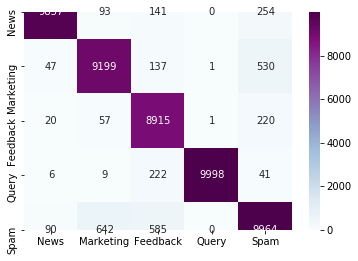

In [20]:
scoring_data(grid,test)

# k-NN Model

next we will try one more model to see how it behaves for which we are using K-NN model


In [65]:

knn_param_grid =dict({'n_neighbors':[1,10,11,12,13,14,15]})
knn_grid = GridSearchCV(KNeighborsClassifier(),cv = 10,param_grid=knn_param_grid) 
knn_grid.fit(train_x,train_y)

KeyboardInterrupt: 

{'n_neighbors': 15}


Text(0.5, 1.0, '10 fold Cross validation result')

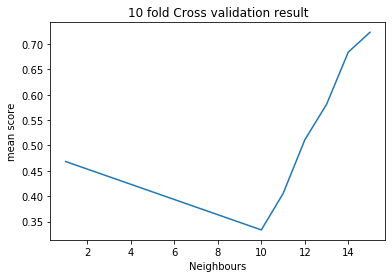

In [57]:
print(knn_grid.best_params_)
score = knn_grid.cv_results_
neighbours = knn_param_grid['n_neighbors']
mean_score = score['mean_test_score']
plt.plot(neighbours,mean_score)
plt.xlabel('Neighbours')
plt.ylabel('mean score')
plt.title("10 fold Cross validation result")

# Scoring
as we can see that we are getting less accuracy that MulticlassNavieBayes i.e only 66 %. Hence we will use Multiclass Naive-Bayes 

Accuracy of Model is 0.6780601811276658
              precision    recall  f1-score   support

           0       0.42      0.99      0.59       755
           1       0.99      0.60      0.74       692
           2       0.90      0.75      0.82       753
           3       0.99      0.33      0.49       770
           4       0.99      0.75      0.86       453

    accuracy                           0.68      3423
   macro avg       0.86      0.68      0.70      3423
weighted avg       0.84      0.68      0.68      3423



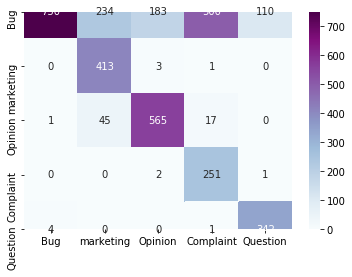

In [58]:
scoring_data(knn_grid,test)

# Export model 
Now we will export model using joblibs


In [21]:
file_model = dump(grid,'grid_big.joblib')
file_encoder = dump(encoder,'encoder_big.joblib')
file_preprocess = dump(preprocess,'preprocessing_big.joblib')
file_vectorizer = dump(vectorizer,'vectorizer_big.joblib')

In [22]:
from joblib import load,dump
cleaner = load('preprocessing_big.joblib')
tfidfvector = load('vectorizer_big.joblib') 
multiclassnaiveBayes = load('grid_big.joblib')
decoder = load('encoder_big.joblib')

# Test The model 

Input article here 


In [57]:
text = str(input("Enter the text : "))
text = cleaner(text)
text = tfidfvector.transform([text])
category = multiclassnaiveBayes.predict(text)
print(decoder.inverse_transform(category))

Enter the text : this is a very nice course
['Feedback']
